<a href="https://colab.research.google.com/github/chr1stine/circle-polygon-classifier/blob/master/geometry_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Генерирование данных

In [1]:
import matplotlib
import numpy
import cv2
import pickle
import pandas
import torch
import torchvision
import PIL

print('matplotlib '+matplotlib.__version__)
print('numpy '+numpy.__version__)
print('cv2 '+cv2.__version__)
print('pandas '+pandas.__version__)
print('torch '+torch.__version__)
print('torchvision '+torchvision.__version__)
print('PIL '+PIL.__version__)

matplotlib 3.2.2
numpy 1.19.5
cv2 4.1.2
pandas 1.1.5
torch 1.8.1+cu101
torchvision 0.9.1+cu101
PIL 7.1.2


## Генерация картинок для датасета

In [2]:
n = 4000 # кол-во картинок для каждого класса
img_size = 128 # размер каждой картинки

### Круги

In [4]:
import matplotlib.pyplot as plt
from numpy import random
import os

# создать папку если такой нет
directory = './figures/circles'
if not os.path.exists(directory):
    os.makedirs(directory)

#параметры - координаты, радиус
def gen_circle(i):
    fig = plt.figure(figsize=(5, 5), dpi=100)

    plt.xlim(0,5)
    plt.ylim(0,5)

    c = (random.rand()*4+1,random.rand()*4+1)
    r = random.rand()*min(c[0],c[1],5-c[0],5-c[1])+random.rand()
    circle = plt.Circle(c, radius=r)
    fig.gca().add_patch(circle)
    fig.gca().set_axis_off()
    plt.savefig('./figures/circles/circle'+str(i)+'.png',bbox_inches='tight',pad_inches=0)
    plt.close()
    
for i in range(n):
    gen_circle(i)

### Квадраты

In [5]:
import matplotlib.pyplot as plt
from numpy import random
import os

# создать папку если такой нет
directory = './figures/polygons'
if not os.path.exists(directory):
    os.makedirs(directory)

def gen_square(i):
    fig = plt.figure(figsize=(5, 5), dpi=100)
    
    x0 = random.rand()*4
    y0 = random.rand()*4
    a = random.rand()*3
    
    plt.xlim(0,5)
    plt.ylim(0,5)
    
    points = []
    
    x = x0-a/2.
    y = y0-a/2
    points.append((x,y))
    
    x = x0-a/2.
    y = y0+a/2.
    points.append((x,y))
    
    x = x0+a/2.
    y = y0+a/2.
    points.append((x,y))
    
    x = x0+a/2.
    y = y0-a/2.
    points.append((x,y))
    
    tetragon = plt.Polygon(points)
    fig.gca().add_patch(tetragon)    
    fig.gca().set_axis_off()
    plt.savefig('figures/polygons/polygon'+str(i)+'.png',bbox_inches='tight',pad_inches=0)
    plt.close()
    
    
for i in range(n):
    gen_square(i)

## Создание датасета

In [8]:
import os
import cv2
import numpy as np
import pickle


file_list = []
class_list = []

folder = "figures"

categories = ["circles", "polygons"]

# Checking or all images in the data folder
for category in categories :
    path = os.path.join(folder, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)

# массив пар (картинка, класс)
training_data = []

def create_training_data():
    for category in categories :
        path = os.path.join(folder, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try :
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array, (img_size, img_size))
                training_data.append([new_array, class_num])
            except Exception as e:
                pass

create_training_data()

# свойства
X = []

# ярлыки
y = []

# в features "попадают" сами картинки, в label - классы
for features, label in training_data:
    X.append(features)
    y.append(label)

# из списка матриц пикселей картинки получаем матрицу списков пикселей картинок
X = np.array(X).reshape(-1, img_size, img_size, 1)

# сериализуем датасет в файл
pickle_out = open("features.pickle", "wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("labels.pickle", "wb")
pickle.dump(y, pickle_out)
pickle_out.close()

## Создание класса для датасета

In [9]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import pickle

class figures_dataset(Dataset):
    def __init__(self):
        features_fname = 'features.pickle'
        labels_fname = 'labels.pickle'
            
        # десериализация картинок
        f_pickle_in = open(features_fname,'rb')
        self.images = pickle.load(f_pickle_in,encoding='bytes')
        
        # десериализация меток
        l_pickle_in = open(labels_fname,'rb')
        self.labels = pickle.load(l_pickle_in,encoding='bytes')
        
        # аугментация и зашумление картинок
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.GaussianBlur(11,11),
            transforms.ToTensor()
        ])
        self.noise = torch.rand(len(self.images),img_size,img_size,1)
        
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # проверка, что индекс "массивоподобный"
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        # возвращение словаря <картинка,метка>
        image = self.images[idx]
        label = self.labels[idx]
            
        image = image + np.array(self.noise[idx])
        image = self.transform(image)
        sample = image, label

        
        return sample

figures = figures_dataset()

# Обучение нейросети

## Вызов DataLoader и объявление нейросети

In [11]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from random import shuffle

# деление датасета на обучающую и проверяющую выборки
validation_split = .2
figures_size = len(figures)
indices = list(range(figures_size))
shuffle(indices)
split = int(np.floor(validation_split * figures_size))
train_indices, test_indices = indices[split:], indices[:split]

# перемешивает индексы
test = SubsetRandomSampler(test_indices)
train = SubsetRandomSampler(train_indices)

# размер батча
b_size=32

test_set = DataLoader(figures, batch_size=b_size, sampler=test)
train_set = DataLoader(figures, batch_size=b_size, sampler=train)


# нейросеть
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
                
        self.conv1 = nn.Conv2d(1, 3, 3)
        self.conv2 = nn.Conv2d(3, 6, 3)
        self.conv3 = nn.Conv2d(6,12,3)
        self.pool = nn.MaxPool2d(2, 2)
        self.dout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(12 * 14 * 14, 2)
    
    def forward(self, x):
        x = self.dout(self.pool(self.conv1(x)))
        x = self.dout(self.pool(self.conv2(x)))
        x = self.dout(self.pool(self.conv3(x)))
        x = torch.flatten(x,1)
        x = self.fc1(x)
        return x
net = Net()

# loss-функция
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Запуск обучения и вывод графика loss

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:132: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))


[1,   200] loss: 0.694
[2,   200] loss: 0.685
[3,   200] loss: 0.673
[4,   200] loss: 0.657
[5,   200] loss: 0.632
[6,   200] loss: 0.560
[7,   200] loss: 0.484
[8,   200] loss: 0.399
[9,   200] loss: 0.352
[10,   200] loss: 0.343
[11,   200] loss: 0.327
[12,   200] loss: 0.302
[13,   200] loss: 0.289
[14,   200] loss: 0.291
[15,   200] loss: 0.265
Finished Training


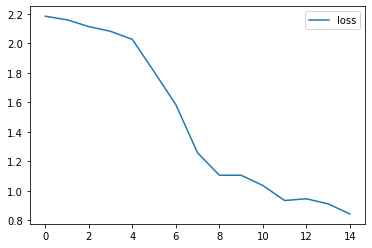

In [12]:
epochs = 15
loss_vals = []
for epoch in range(epochs):

    running_loss = 0.0 # для вывода по каждым freq мини-батчам
    loss_val = 0.0 # для вывода общего loss по эпохе
    for i, data in enumerate(train_set, 0):

        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()

        # вывод loss
        running_loss += loss.item()
        loss_val = loss_val+running_loss
        freq = 200  # каждые freq мини-батчей
        if i % freq == freq-1:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / freq))
            running_loss = 0.0
    
    loss_vals.append(loss_val/(b_size*len(train_set)))

plt.plot(range(epochs),loss_vals)
plt.legend(['loss'])
print('Finished Training')

## Измерение качества

In [13]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_set:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Точность нейросети на тестовой выборке: %d %%' % (100 * correct / total))


class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))
with torch.no_grad():
    for data in test_set:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(b_size):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

classes = ['кругов','квадратов']
for i in range(2):
    print('Точность %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Точность нейросети на тестовой выборке: 81 %
Точность кругов : 95 %
Точность квадратов : 67 %


# Тест на одной картинке

## На случайной из тестового датасета

In [ ]:
# выбор случайного батча
data = next(iter(test_set))

# отсечение первой картинки из выбранного батча
img, label = data[0][0],[0]
img1 = img.squeeze(0)
plt.imshow(img1)
plt.show()

# определение отклика
image = data[0][:1]
outputs = net(image)
_, predicted = torch.max(outputs, 1)
print('prediction: ',classes[predicted[0]])

## На конкретном файле

In [ ]:
# указание файла с тестовой картинкой
fname = './figures/polygons/polygon6.png'

# считывание, перевод в массив
img_array = cv2.imread(os.path.join('.', fname), cv2.IMREAD_GRAYSCALE)# чтение картинки в чб
new_array = cv2.resize(img_array, (img_size, img_size))# масштабирование картинки под нейронку
X = []
for features in new_array:
    X.append(features)
X = np.array(X).reshape(1, 1, img_size, img_size)

# получение отклика
outputs = net(torch.Tensor(X[:1]))
_, predicted = torch.max(outputs,1)
classes = ['круг','квадрат']
print(classes[predicted[0]])